In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.set_device(0)
import os
from pathlib import Path
import json
from fastai import *
from fastai.dataset import *
from fastai.conv_learner import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patheffects

## Load Data

In [4]:
data_dir = Path('/mnt/data/extracts/pascal')
JPEGS = data_dir/'VOCdevkit/VOC2007/JPEGImages/'

In [5]:
train = json.load(open(data_dir/'pascal_train2007.json'))
val = json.load(open(data_dir/'pascal_val2007.json'))
test = json.load(open(data_dir/'pascal_test2007.json'))

### Create File Lookups

In [6]:
all_images = train['images'] + val['images'] + test['images']
fnid = {x['file_name']: x['id'] for x in all_images}

### Create DataFrames

In [7]:
def bb_np(bbox_hw):
    return [bbox_hw[1], bbox_hw[0], 
            bbox_hw[1] + bbox_hw[3], 
            bbox_hw[0] + bbox_hw[2]]

def bb_hw(bbox_np):
    return [bbox_np[1], bbox_np[0], 
            bbox_np[3] - bbox_np[1],
            bbox_np[2] - bbox_np[0]]

def create_df(d):
    anno = d['annotations']
    fnid = [{'file_name': x['file_name'], 'image_id': x['id']} for x in d['images']]
    cats = [{'category_id': x['id'], 'category_name': x['name']} for x in d['categories']]
    anno_df = pd.DataFrame.from_dict(anno)
    fname_df = pd.DataFrame.from_dict(fnid)
    cat_df = pd.DataFrame(cats)
    df = pd.merge(anno_df, cat_df, how='inner', on='category_id')
    df = pd.merge(df, fname_df, how='inner', on='image_id')
    df['bbox_np'] = df['bbox'].apply(lambda x: bb_np(x))
    df = df.loc[df.ignore != 1]
    return df

def get_largest(df):
    return df.sort_values('area', ascending=False).groupby(['image_id']).first().reset_index()

In [8]:
train_df = create_df(train)
val_df = create_df(val)
test_df = create_df(test)
comb_df = pd.concat([train_df, val_df], axis=0)

In [9]:
trn_lrg_df = get_largest(train_df)
val_lrg_df = get_largest(val_df)
comb_lrg_df = get_largest(comb_df)

### Setup Plotting Functions

In [10]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_anno(ax, x, y, anno):
    text = ax.text(x, y, anno, fontsize=14, color='white', weight='bold', 
                   verticalalignment='top')
    draw_outline(text, 1)
    
def draw_rect(ax, bbox):
    x = bbox[0]
    y = bbox[1]
    h = bbox[2]
    w = bbox[3]
    ax.add_patch(patches.Rectangle((x, y), h, w, fill=False, edgecolor='white', lw=2))
    
def show_img(img, ax=None, figsize=(16, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax
    
def plot_idx(image_id, figsize=(16, 8)):
    rel = comb_lrg_df.loc[comb_lrg_df.image_id == image_id].iloc[0]
    fname = rel.file_name
    cat = rel.category_name
    bbox = rel.bbox
    f_path = JPEGS/fname
    img = open_image(f_path)
    ax = show_img(img, figsize=figsize)
    draw_rect(ax, bbox)
    draw_anno(ax, bbox[0], bbox[1], cat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Multiclass Classification

In [113]:
TMP = data_dir/'tmp'
TMP.mkdir(exist_ok=True)
MC_CSV = TMP/'MC.CSV'
MODEL = Path('/mnt/models/pascal')
f_model = resnet34
sz = 224

In [114]:
def create_mc_df(df):
    df1 = df.copy()
    df1 = df1[['file_name', 'image_id', 'category_name']]
    df2 = (df1.groupby(['file_name', 'image_id'])
           .apply(lambda x: pd.Series({'m_cat': ' '.join(set(x.category_name))}))
           .reset_index())
    df2 = (df2[['file_name', 'm_cat']]
           .rename(columns={'file_name': 'fname'}))
    return df2

In [146]:
def matching_cl(onehot_y, md, thresh=0):
    return list(np.array(md.classes)[np.where(onehot_y > thresh)])

In [157]:
def plot_mc(x, y, thresh=0):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        show_img(np.squeeze(md.trn_ds.denorm(x[i])), ax=ax, figsize=(12, 8))
        txt_x = 0
        txt_y = 0
        for cl in matching_cl(y[i], md, thresh):
            draw_anno(ax, txt_x, txt_y, cl)
            txt_y += 20
    plt.tight_layout()

In [153]:
mc_df = create_mc_df(train_df)
mc_df.to_csv(MC_CSV, index=False)

In [154]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, 
                       max_zoom=1.1, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(MODEL, JPEGS, MC_CSV, tfms=tfms, skip_header=True)

In [155]:
x, y = list(next(iter(md.trn_dl)))
x, y = to_np(x), to_np(y)

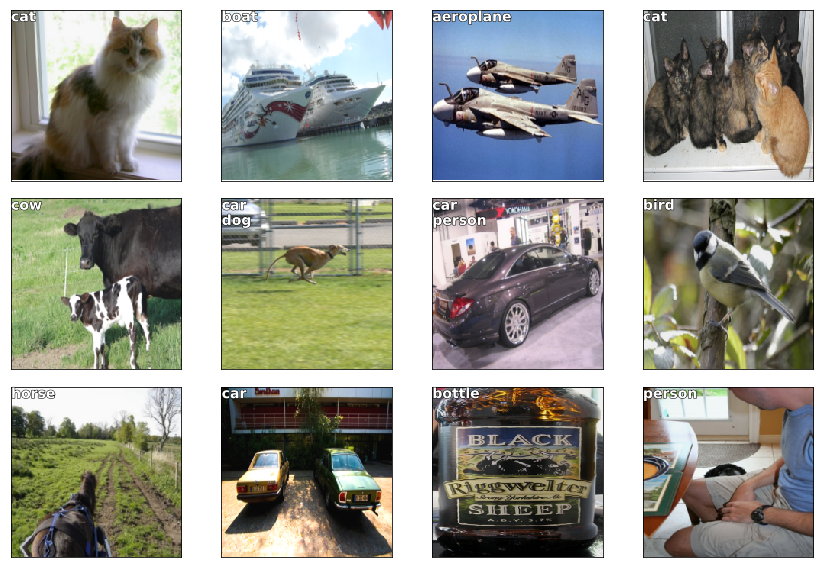

In [156]:
plot_mc(x, y)

In [121]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [122]:
learn.lr_find()
learn.sched.plot()
lr = 2e-2

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.375109   7.132112   0.741564  



In [126]:
learn.fit(lr, n_cycle=1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.306273   0.109346   0.963785  
    1      0.169842   0.076892   0.973918                  
    2      0.120938   0.075992   0.973625                  



[0.07599212, 0.9736253023147583]

In [127]:
learn.fit(lr, n_cycle=1, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.103553   0.082534   0.972799  
    1      0.088422   0.075972   0.972701                   



[0.0759718, 0.9727013260126114]

In [129]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:21<00:03,  1.27it/s, loss=0.389] 

In [161]:
preds = to_np(predict_batch(learn.model, x))

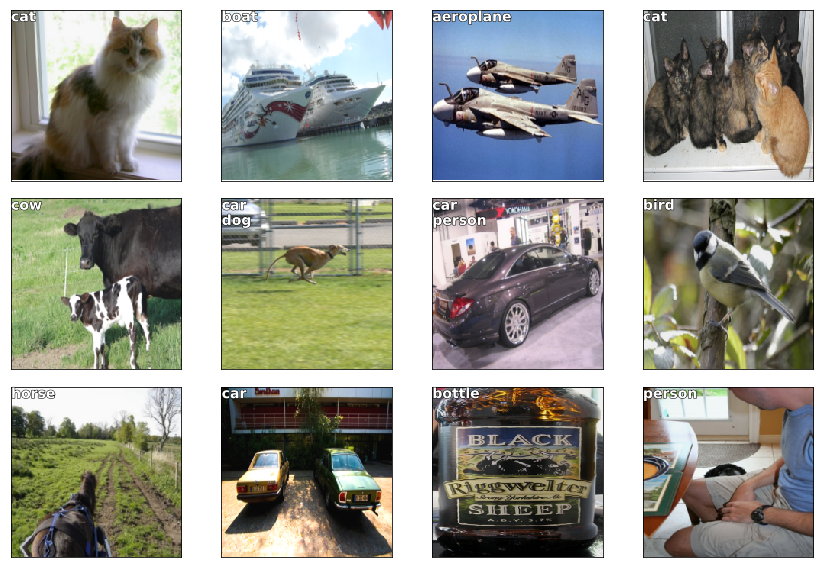

In [163]:
plot_mc(x, y)

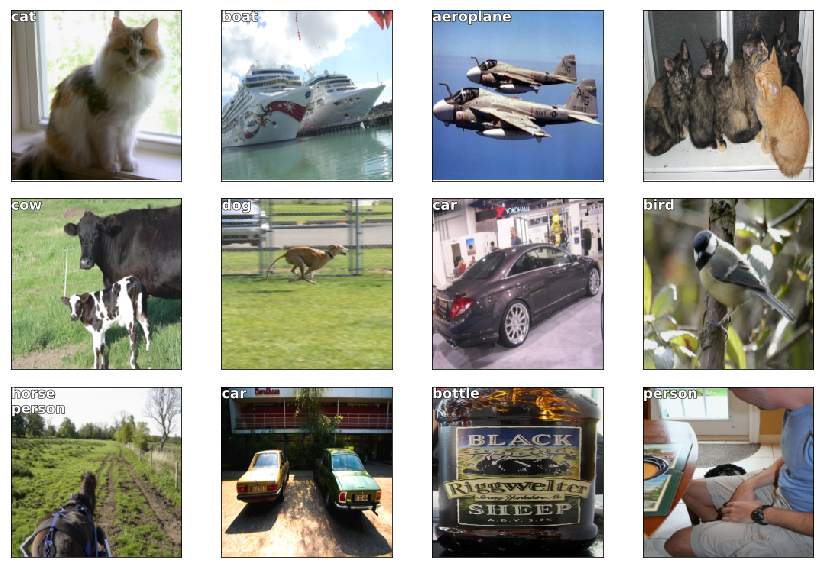

In [164]:
plot_mc(x, preds, 0.5)

## Object Detection with 4 2x2 anchor